<a href="https://colab.research.google.com/github/eftekhari-mhs/population-protocols/blob/master/Exact_Majority/json_interpreter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A stable majority population protocol using logarithmic time and states

In this notebook, we will focus on the exact majority protocol of [this](paperlink) paper. For a better understating of this notebook, we suggest you start by reading the paper.

The Java simulator of the protocol is also available on [Github](https://github.com/eftekhari-mhs/population-protocols/blob/master/Exact_Majority/Agent.java). The simulator goes through phases $0$ to $9$ of the protocol and take snapshots of all agents' state in every $n$ interactions ~roughly 1 unit of time. (throughout the notebook $n$ is the population size)

The java simulator stores the snapshot in a JSON formatted file. For more information about the JSON representation of the agents read the [readme](https://github.com/eftekhari-mhs/population-protocols/blob/master/Exact_Majority/README.md) file. 

**To use this notebook, click on 'Runtime' and select 'Run all'**.

# Code for fetching data and creating plots

In [ ]:
#@title Technical details: Loading JSON
import json
from types import SimpleNamespace

import pandas as pd
import numpy as np
from numpy.random import randint

from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt

from collections import defaultdict 

import requests

url = 'https://raw.githubusercontent.com/eftekhari-mhs/population-protocols/master/Exact_Majority/majority_flat_json_'#"/content/drive/My Drive/Colab_majority/pub/majority_flat_json_"
def load_file(description, k):
  filename = url+description+".json"  
  req = requests.get(filename)
  req = req.text
  # print(req)
  data = json.loads(req)
  
  return data

In [ ]:
#@title Technical details: State Abtraction


from dataclasses import dataclass
from typing import Optional
import matplotlib as plt

from enum import Enum
class Role(Enum):
  Main = 'Main'
  Reserve = 'Reserve'
  Clock = 'Clock'
  MCR = 'MCR'
  CR = 'CR'  

class Bias(Enum):
  A = 'A'
  B = 'B'
  T = 'T'
  Null = ''

@dataclass(frozen=True)
class State:
  phase: int
  level: int
  minute: int
  hour: int
  sample: int
  full: bool
  role: Role
  bias: int
  output: Bias
  counter: Optional[int] = None  

In [ ]:
#@title Technical details: Building dataframe for each field of an agent
#
#
#@markdown This section contains the functions that we use to retrieve data from JSON files. We make 
#@markdown a dataframe for each field of an agent to make the access easier. 
#
#@markdown Initial gaps:  for linear is n/10, for the constant case initial gap= 2

#@markdown **To reveal the hidden code double click on this section.**
#

role_key = "role"
phase_key = "phase"
bias_key = "bias"
full_key = "full"
output_key = "output"
exponent_key = "exponent"
minute_key = "minute"
hour_key = "hour"
sample_key = "sample"
counter_key = "counter"

file_description = "N_5122666_LOG_23" #@param ["N_5122666_LOG_23"]
#, "N_2451828_LOG_22"]
_N = int(file_description.split('_')[1])
_LOG = int(file_description.split('_')[3])
p_value = "0.1"#@param ["0.1"]
#["0.01", "0.1", "1"] 
k_value = "2"#@param ["2"]
#["2","3","4", "5"] 
c_value = "5"#@param ["5"] 
#["1","2","3","4", "5"] 
initial_gap = "tie" #@param ["constant", "tie", "linear", "sqrt"]


file_description = "{}_gap_N_{}_LOG_{}_P_{:.6f}_K_{}_C{}".format(initial_gap,_N, _LOG, float(p_value), int(k_value), int(c_value))

print(f"n: {_N}; log(n): {_LOG}; dripping probability: {p_value}; max level {k_value} log(n) (number of minutes).")     
data = load_file(file_description, k_value)

import math

#define columns for each dataframe based on possible values
def init_dataframe(field_name, all_biases=False):
  m = 1
  if all_biases:
    m = 4
  if field_name == phase_key:
    df = pd.DataFrame(columns=list(range(0, 10))) # should change based on the case  
  elif field_name == exponent_key:
    df = pd.DataFrame(columns=list(range(-_LOG, m))) 
  elif field_name == minute_key:
    df = pd.DataFrame(columns=list(range(0, int(k_value) * _LOG + 1))) 
  elif field_name == hour_key:
    df = pd.DataFrame(columns=list(range(0, _LOG + 1))) 
  elif field_name == sample_key:
    df = pd.DataFrame(columns=list(range(-_LOG, 0))) 
  elif field_name == counter_key:
    df = pd.DataFrame(columns=list(range(0, k_value * _LOG + 1)))
  elif field_name == full_key:
    df = pd.DataFrame(columns=[True, False])
  elif field_name == role_key:
    df = pd.DataFrame(columns=[r for r in Role])
  elif field_name == output_key:
    df = pd.DataFrame(columns=[b for b in Bias])
  elif field_name == bias_key:
    if all_biases:
      df = pd.DataFrame(columns=list(range(-3, 4)))
    else:
      df = pd.DataFrame(columns=list(range(-1, 2)))
  else:
    print("unexpected value")
    df = pd.DataFrame()
  return df

def build_dict(field_name, all_states):
  new_row = defaultdict(int) 
  for state, count in all_states.items(): # Iterates through the pairs of state and count
    if field_name == phase_key:
      new_row[state.phase]+=count
    if field_name == exponent_key:
      if state.level == 0 and state.bias > 1:
        new_row[state.bias - 1]+=count  
      if state.level == 0 and state.bias < -1:
        new_row[abs(state.bias) - 1]+=count  
      new_row[state.level]+=count
    if field_name == minute_key:
      new_row[state.minute]+=count
    if field_name == hour_key:
      new_row[state.hour]+=count
    if field_name == sample_key:
      new_row[state.sample]+=count      
    if field_name == role_key:
      new_row[state.role]+=count
    if field_name == bias_key:
      new_row[state.bias]+=count
    if field_name == output_key:
      new_row[state.output]+=count
    if field_name == full_key:
      new_row[state.full]+=count
  return new_row

def valid(x_limit, x):
  return (x_limit == "" or x_limit == x)

def valid_bias(x_limit, x):
  if x_limit == "":
    return True
  if x_limit == "pos" and x > 0:
    return True
  if x_limit == "neg" and x < 0:
    return True
  return False

def build_dataframe(field_name, role_limit = "", phase_limit = "", bias_limit = "", all_biases = False): 
  p = True
  
  df = init_dataframe(field_name, all_biases)
  for tikz,statesList in data["interactions"].items(): 
    clock = 0 
    all_states = defaultdict(lambda: 0) #dict()    
    for state, count in statesList:
      phase = state[phase_key]
      level = state[exponent_key]
      minute = state[minute_key]
      hour = state[hour_key]
      sample = state[sample_key]
      full = state[full_key]
      role = Role(state[role_key])
      if all_biases:
        bias = state[bias_key]
      else:
        if state[bias_key] > 0:
          bias = 1
        elif state[bias_key] < 0:
          bias = -1
        elif state[bias_key] == 0:
          bias = 0
      output = Bias(state[output_key])
      
      if valid(role_limit, role) and valid(phase_limit, phase) and valid_bias(bias_limit, bias):          
        result = State(phase = phase, level = level, minute = minute, hour = hour, sample = sample, full=full, role =role, bias = bias, output = output)
        all_states[result] += count      
    
    df.loc[int(tikz)/_N] = build_dict(field_name, all_states)
  df = df.fillna(0)
  
  return df

n: 5122666; log(n): 23; dripping probability: 0.1; max level 2 log(n) (number of minutes).


In the following code block, we will use the ``build_datafram(fieldname)`` function on ``phase_key`` to generate a dataframe that shows the changes of phase field in the agents over the course of a simulation. 

Each element in this dataframe represents the count of specific agents in the whole popualtion. For example, element(i, j) shows how many agents after $i$ interactions have their phase field equal to $j$. 

All agents start in phase $0$ and end the computation in either phase $2$ (in the case of large initial gap) ,  phase $4$ (in the case of tie), and phase $9$ (w.h.p), or phase $10$ (slow back-up which is not shown here)

In [ ]:
#@title Initialize all dataframes

# TODO : update the above texts
max_yaxis = _N * (1.1) # for all plots
df_phase = build_dataframe(phase_key)
#load all the data frames
df_bias = build_dataframe(bias_key, role_limit=Role.Main)
df_exponent = build_dataframe(exponent_key, role_limit=Role.Main)
df_exp_a = build_dataframe(exponent_key, bias_limit= "pos", all_biases=True)
df_exp_b = build_dataframe(exponent_key, bias_limit= "neg", all_biases=True)
df_minutes = build_dataframe(minute_key, role_limit=Role.Clock)
df_hour = build_dataframe(hour_key)

# Let us print one as an example
# df_exp_b

In [ ]:
#@title Code for plotting

font = {'family': 'serif',
          'color':  'darkblue',
          'weight': 'normal',
          'size': 15,
          }
font_large = {'family': 'serif',
          'color':  'black',
          'weight': 'normal',
          'size': 16,
          }
def gen_phase_tikz(df_phase, c=0):
  phase_labels = []
  empty_phase_labels = []
  m=10
  if initial_gap=="linear":
    m=3
  if initial_gap=="tie":
    m=5
  starts = np.array(range(0,m))
  ends = np.array(range(0,m))
  phase_mids = np.array(range(0,m+c))
  for i in range(0,m):       
    empty_phase_labels.append(" ") 
    if i==3 and c!=0:
      phase_labels.append(f"{i}a")  
      phase_labels.append(f"{i}b")  
      phase_labels.append(f"{i}c")  
    else:
      if i<2:
        phase_labels.append(f"phase={i}")          
      else:
        phase_labels.append(f"{i}")  
        
    
  for index, row in df_phase.iterrows():
    for i in range(0,m):
      if row[i] > 0 and starts[i] == i:
        starts[i] = index+5
      elif row[i] == 0 and ends[i] == i and starts[i] != i:
        ends[i] = index+5
      
  ends[m-1] = len(df_phase)    
  for i in range(0, m):    
    if c==0:
      phase_mids[i] = (ends[i]-starts[i])/2 + starts[i]    
    else:
      if i<3:
        phase_mids[i] = (ends[i]-starts[i])/2 + starts[i]    
      if i == 3:
        l = ends[i]-starts[i]
        phase_mids[i] = starts[i]+(l*0.25)
        phase_mids[i+1] = starts[i]+(l*0.5)
        phase_mids[i+2] = starts[i]+(l*0.75)
      if i>3:
        phase_mids[i+2] = (ends[i]-starts[i])/2 + starts[i]    
   
  return phase_labels, starts, phase_mids, ends, empty_phase_labels

def gen_y_tikz(n, log = False):
  x_labels = []  
  x_ticks = [1, 2, 4, 8, 16, 32] #denominators for n in the y-axis
  for i in x_ticks:
    if i == 1:
      x_labels.append(f"n")  
    else:
      x_labels.append(f"n/{i}")  

  for i in range(0,len(x_ticks)):
    x_ticks[i] = n/x_ticks[i]  

  if log:
    for i in range(0,int(np.log10(_N)) - 1):
      x_labels.append(str(10 ** i))
      x_ticks.append(10 ** i)
    for i in [2, 0, -1, -10, -100]:
      x_labels.append(str(i))
      x_ticks.append(i)
  return x_labels, x_ticks

phase_label , phase_starts, phase_mids, phase_ends, empty_phase_labels = gen_phase_tikz(df_phase)
# phase_label , phase_tikz, phase_starts, phase_ends = gen_phase_tikz(df_phase, 2) #case of 3 extra points in phase 3
ylabel , ytikz = gen_y_tikz(_N, log = False)
ylabel_log, ytikz_log = gen_y_tikz(_N, log = True)

def x_axis_phase_labels(ax):
  ax.set_xticks([p + 2 for p in phase_starts], minor = True)
  phase_labels = ['phase='+str(i) for i in range(10)]
  if initial_gap in ['constant', 'tie']:
    phase_labels[2] = ''
  if initial_gap == 'constant':
    phase_labels[4] = ''
  ax.set_xticklabels(phase_labels, fontdict=font, minor=True, ha = 'left')
  ax.set_xticks(phase_starts[1:], minor = False)
  ax.set_xticklabels([''] * (len(phase_starts) - 1), fontdict=font, minor=False)
  ax.tick_params('x', length=0, width=0, which='minor')
  ax.tick_params('x', length=30, width=2, which='major')

# get hour start times
if initial_gap in ['constant', 'tie']:
  clock_pop = sum(df_minutes.iloc[phase_mids[3]])
  hour_start_times = []
  t = 0
  for h in range(_LOG+ 1):
    while sum(df_minutes.iloc[t][2 * h:]) < 0.1 * clock_pop:
      t += 1
    hour_start_times.append(t)

In [ ]:
#@title Code for generating snapshots

def plot_bias_distribution(time, a_exp, b_exp, yscale = "linear", ymax=_N):
  a_exp_dist = np.array([a_exp[i][time] for i in range(-_LOG, 3)])
  b_exp_dist = np.array([b_exp[i][time] for i in range(-_LOG, 3)])

  # Width of a bar 
  width = 0.3       
  a = np.array([i+width/2 for i in range(-_LOG, 3)])
  b = np.array([i-width/2 for i in range(-_LOG, 3)])
  # Plotting
  ax1.clear()
  ax1.bar(b,b_exp_dist, width, label='B Exponents', color= 'darkblue', alpha=0.9)
  ax1.bar(a,a_exp_dist, width, label='A Exponents', color= 'brown', alpha = 0.9)

  plt.ylabel('Count of Agents', fontdict=font)
  plt.xlabel('|Bias|', fontdict= font)
  plt.xticks(range(-_LOG, 3), ['2^(' + str(i) + ')' for i in range(-_LOG, -2)] + ['1/4', '1/2', '1', '2', '3'], fontsize = 16)
  current_phase = max([0] + [i for i, t in enumerate(phase_tikz) if t <= time])
  if current_phase == 3:
    current_hour = max([-1] + [i for i, t in enumerate(hour_start_times) if t <= time])
    plt.title(f"Time step {time} (Hour {current_hour} in Phase {current_phase})", fontdict=font)
  else:
    plt.title(f"Time step {time} (Phase {current_phase})", fontdict=font)

  minx = min([i for i,v in enumerate(a_exp_dist) if v != 0] + [i for i,v in enumerate(b_exp_dist) if v != 0])
  maxx = max([i for i,v in enumerate(a_exp_dist) if v != 0] + [i for i,v in enumerate(b_exp_dist) if v != 0])
  maxy = max([v for i,v in enumerate(a_exp_dist) if v != 0] + [v for i,v in enumerate(b_exp_dist) if v != 0])
  height = min(_N, max(_N/16 , 2*maxy))
  for i, v in enumerate(b_exp_dist):    
    if v != 0 :
      plt.text(b[i], v + 0.12*height, str(v), color='blue', fontsize=14, ha = 'center')
      plt.arrow(b[i], v + 0.11*height, 0, -0.07 * height, head_width=0.05, head_length=0.03 * height)
  for i, v in enumerate(a_exp_dist):
    if v != 0 :
      plt.text(a[i], v + 0.2*height, str(v), color='brown', fontsize=14, ha = 'center')
      plt.arrow(a[i], v + 0.19*height, 0, -0.15 * height, head_width=0.05, head_length=0.03 * height)

  plt.xlim(minx-_LOG-1, maxx-_LOG+1)  
  plt.yscale(yscale)
  plt.yticks(ytikz, ylabel, fontsize = '16')#, fontdict=font)
  plt.ylim(bottom = 1, top = height)

# Plots

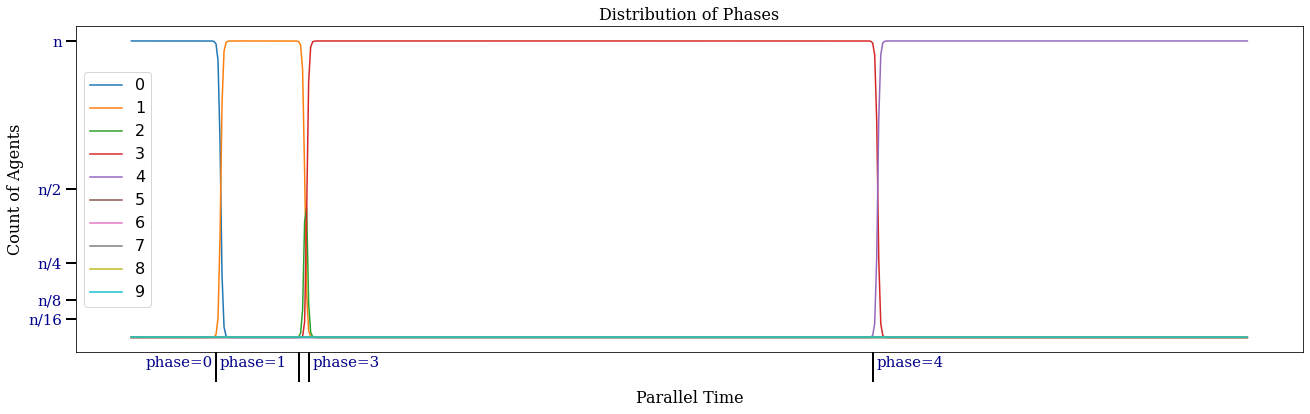

In [ ]:
#@title Plot phase distribution

ax = df_phase.plot(figsize = (22,6), fontsize=1, label = [f'phase={i}' for i in range(10)])
ax.legend([f'phase={i}' for i in range(10)])

ax.set_yticks(ytikz[:-1], minor=False)
ax.set_yticklabels(ylabel[:-1], fontdict=font, minor=False)
ax.legend(loc='center left', prop={'size': 16})
ax.tick_params('y', length=10, width=2, which='major')

x_axis_phase_labels(ax)

ax.set_xlabel("Parallel Time", fontdict= font_large)
ax.set_ylabel("Count of Agents", fontdict= font_large)
ax.set_title("Distribution of Phases", fontdict= font_large)
# ax.set_ylim(0, max_yaxis)

# export files
if initial_gap in ['constant']:
  fig = ax.get_figure()
  fig.savefig('phases_' + initial_gap + '_gap.svg')
  fig.savefig('phases_' + initial_gap + '_gap.pdf')

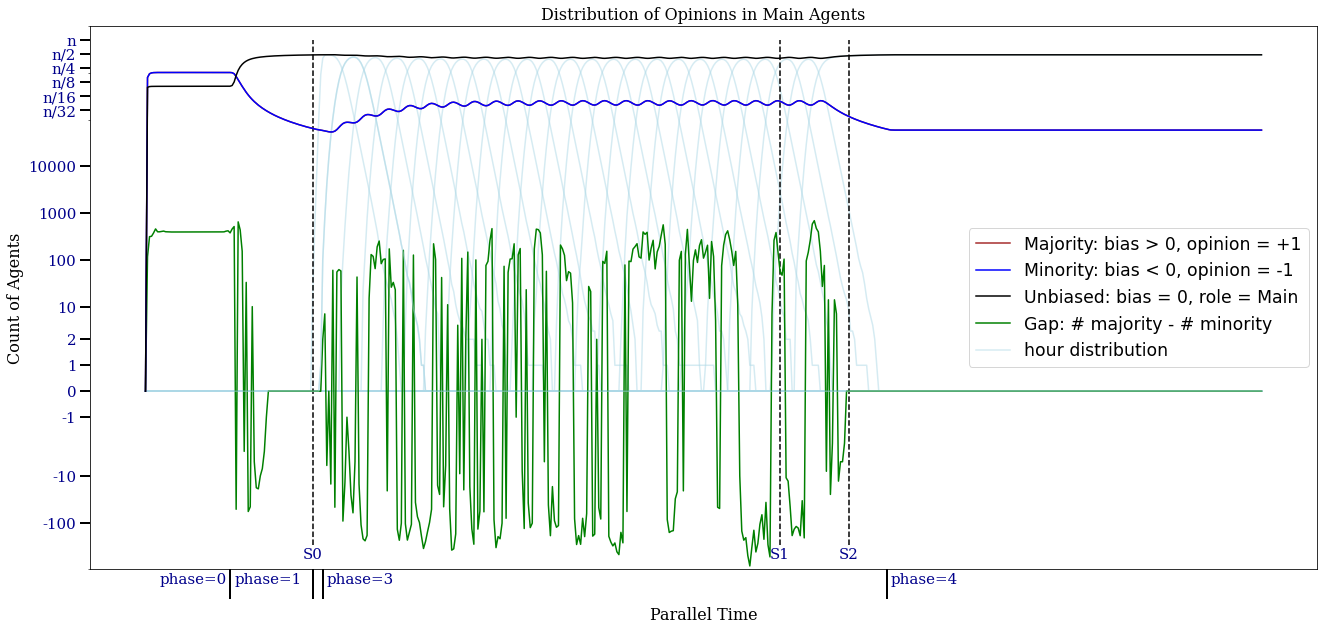

In [ ]:
#@title Plot distribution of Main agents
 
figsizes = {'constant': (22,10), 'linear': (12, 6), 'tie': (22,10)}
ax = df_bias[:][1].plot(figsize = figsizes[initial_gap], color = 'brown', zorder = 3)
df_bias[:][-1].plot(ax = ax, color = 'blue', zorder = 3)
df_bias[:][0].plot(ax = ax, color = 'black', zorder = 3)
x_axis_phase_labels(ax)

(df_bias[:][1] - df_bias[:][-1]).plot(ax=ax, color = 'green', zorder = 2) #, label = "gap #(+1) - #(-1)") 
if initial_gap == 'constant':
  df_hour[1].plot(ax=ax, color = 'lightblue', alpha=0.5) #, legend=True, label='hour distribution')
  # other hours don't show up on the legend
  df_hour.plot(ax=ax, color = 'lightblue', alpha=0.5, label='_nolegend_', zorder = 1)
  ax.legend(['Majority: bias > 0, opinion = +1', 'Minority: bias < 0, opinion = -1', 
            'Unbiased: bias = 0, role = Main', 'Gap: # majority - # minority','hour distribution'], 
            fontsize = 'xx-large', loc = 'upper right', bbox_to_anchor=(1, 0.9))
if initial_gap == 'tie':
  df_hour[1].plot(ax=ax, color = 'lightblue', alpha=0.5) #, legend=True, label='hour distribution')
  # other hours don't show up on the legend
  df_hour.plot(ax=ax, color = 'lightblue', alpha=0.5, label='_nolegend_', zorder = 1)
  ax.legend(['Majority: bias > 0, opinion = +1', 'Minority: bias < 0, opinion = -1', 
            'Unbiased: bias = 0, role = Main', 'Gap: # majority - # minority','hour distribution'], 
            fontsize = 'xx-large', loc = 'right')
if initial_gap == 'linear':
    ax.legend(['Majority: bias > 0, opinion = +1', 'Minority: bias < 0, opinion = -1', 
            'Unbiased: bias = 0, role = Main', 'Gap: # majority - # minority'], 
            fontsize = 'x-large', loc = 'lower right')

ax.set_xlabel("Parallel Time", fontdict= font_large)
ax.set_ylabel("Count of Agents", fontdict= font_large)
#add both log and linear plots to see the minority counts

if initial_gap == 'constant':
  snapshot_times = [90, 191, 265, 286, 364, 440, 460]
  log = True
  ax.vlines(snapshot_times, -300, _N, linestyles = 'dashed')
  for i, s in enumerate(snapshot_times):
    ax.text(s, -600, 'S' + str(i), ha = 'center', fontdict = font)
if initial_gap == 'linear':
  log = False
  snapshot_times = [40, 81]
  ax.vlines(snapshot_times, _N / 30, _N, linestyles = 'dashed')
  for i, s in enumerate(snapshot_times):
    ax.text(s, _N / 100, 'S' + str(i), ha = 'center', fontdict = font)
if initial_gap == 'tie':
  snapshot_times = [83,315, 349]
  log = True
  ax.vlines(snapshot_times, -300, _N, linestyles = 'dashed')
  for i, s in enumerate(snapshot_times):
    ax.text(s, -600, 'S' + str(i), ha = 'center', fontdict = font)


#set y axis labels to fractions of n
if log:
  ax.set_yscale('symlog') 
  ax.set_yticks(ytikz_log, minor=False)
  ax.set_yticklabels(ylabel_log, fontdict=font, minor=False)
  ax.set_ylim(-1000,2*_N)
else:
  ax.set_yticks(ytikz, minor=False)
  ax.set_yticklabels(ylabel, fontdict=font, minor=False)
  if initial_gap == 'linear':
    ax.set_ylim(0, 0.4 * _N)
  if initial_gap == 'tie':
    ax.set_ylim(0, _N)

ax.tick_params('y', length=10, width=2, which='major')



ax.set_title("Distribution of Opinions in Main Agents", fontdict= font_large)
# export files
if initial_gap in ['constant','linear','tie']:
  fig = ax.get_figure()
  fig.savefig('main_opinions_'+initial_gap+'_gap.svg')
  fig.savefig('main_opinions_'+initial_gap+'_gap.pdf')

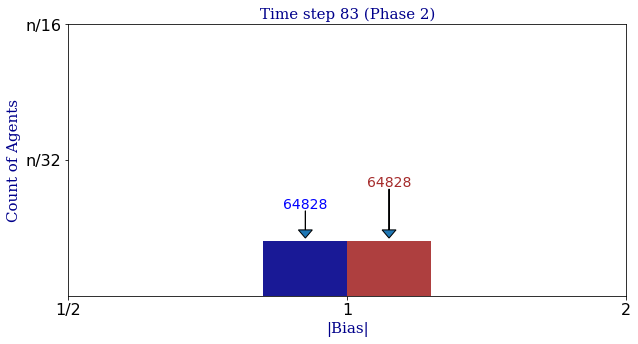

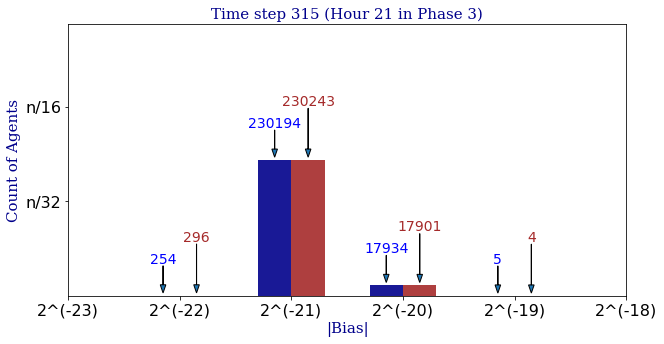

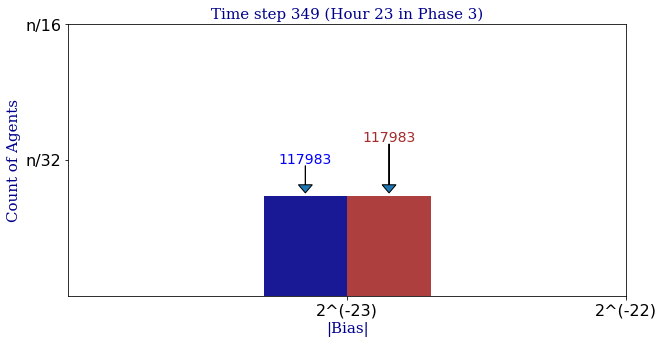

In [ ]:
#@title Plot all specified snapshots

for i,time in enumerate(snapshot_times):
  fig = plt.figure(figsize = (10, 5))
  ax1 = fig.add_subplot()
  plot_bias_distribution(time, df_exp_a, df_exp_b)
  fig.savefig('snapshot_' + str(i) + '_' + initial_gap+'_gap.svg')
  fig.savefig('snapshot_' + str(i) + '_' + initial_gap+'_gap.pdf')

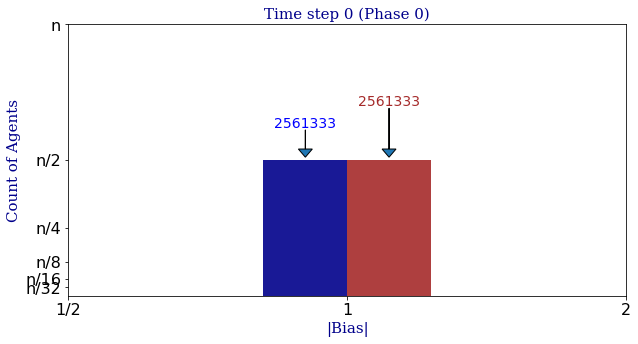

In [ ]:
#@title Create animation with snapshots at all times

from matplotlib import pyplot as plt

animation_lengths = {'constant': 540, 'linear':83, 'tie': 365}

fig = plt.figure(figsize = (10, 5))
ax1 = fig.add_subplot()
ani = animation.FuncAnimation(fig, plot_bias_distribution, 
                              frames = animation_lengths[initial_gap], 
                              fargs = (df_exp_a, df_exp_b))
js = ani.to_jshtml()
HTML(js)
with open('animation_' + initial_gap + '_gap.html','w') as f:
  f.write(js)

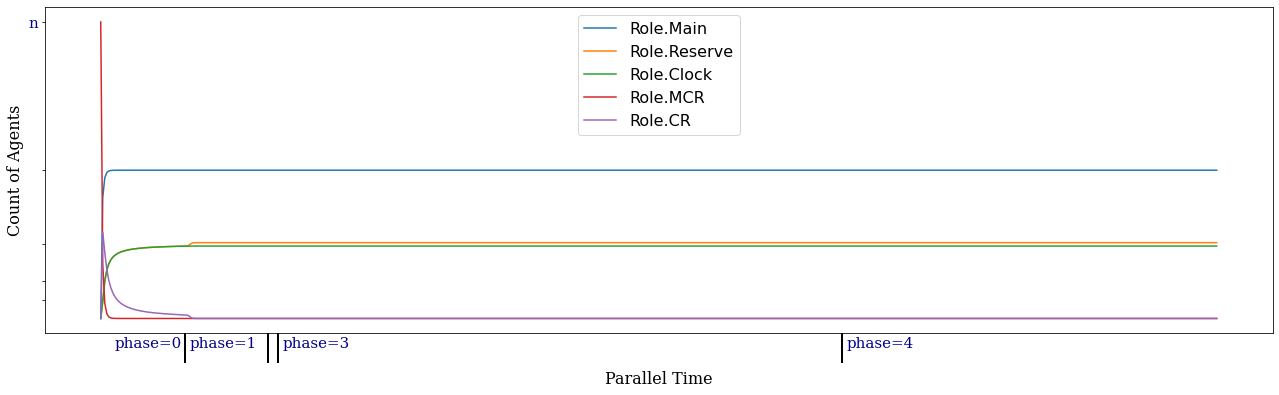

In [ ]:
#@title Plot distribution of roles

ax = build_dataframe(role_key).plot(figsize = (22,6))
ax.legend(['a','b','c','d','e'])

ax.legend(loc='upper center', prop={'size': 16})
ax.set_xlabel("Parallel Time", fontdict= font_large)
ax.set_ylabel("Count of Agents", fontdict= font_large)
x_axis_phase_labels(ax)

# df_phase.plot(ax=ax, alpha =0.2, legend=False) 

#set y axis labels to fractions of n
ax.set_yticks(ytikz[:-1], minor=False)
ax.set_yticklabels(ylabel[:1], fontdict=font, minor=False)

#set x axis labels to phase numbers
# ax.set_xticks(phase_tikz, minor=False)
# ax.set_xticklabels(empty_phase_labels, fontdict=font, minor=False)
# ax.tick_params('both', length=10, width=2, which='major')

# export files
if initial_gap == 'constant':
  fig = ax.get_figure()
  ax.set_title("Distribution of Roles", fontdict= font_large)
  fig.savefig('roles_' + initial_gap + '_gap.svg')
  fig.savefig('roles_' + initial_gap + '_gap.pdf')

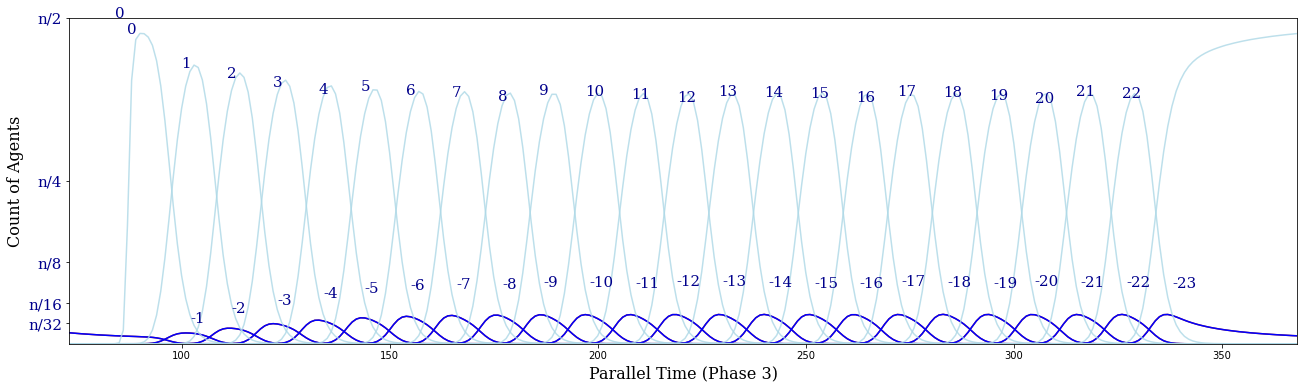

In [ ]:
#@title Plot distributions of hours and exponents

ax = df_exp_a.plot(figsize = (22,6), color = 'brown', legend = False)
# df_exp_a.plot(ax = ax, color = 'brown', label='_nolegend_')
# df_exp_b[1].plot(ax = ax, color = 'blue')
df_exp_b.plot(ax = ax, color = 'blue', label='_nolegend_', legend = False)
# df_hour[1].plot(ax = ax, color = 'lightblue', alpha=0.8)
df_hour.plot(ax = ax, color = 'lightblue', alpha=0.8, label='_nolegend_', legend = False)
# ax.legend(['a','b','c'])

# add labels at the end of lines:
# for line, name in zip(ax.lines, df_exponent.columns):
#     y = line.get_ydata()[-1]
#     ax.annotate(name, xy=(1,y), xytext=(16,10), color=line.get_color(), 
#                 xycoords = ax.get_yaxis_transform(), textcoords="offset points",
#                 size=14, va="center")# for i, v in enumerate(df_exponent):



# add labels to exponent lines
for col in df_exponent.columns:
    printed = True
    old = 0
    for id, val in enumerate(df_exponent[col]):
        if printed and old > val:
          printed = False
          ax.text(id, val + 100, str(col), fontdict=font)
        old = val

# add labels to hour lines
for col in df_hour.columns:
    printed = True
    old = 0
    for id, val in enumerate(df_hour[col]):
        if printed and old > val:
          printed = False          
          ax.text(id-4, val + 100, str(col), fontdict=font)
        old = val
# ax.set_yscale('log')

ax.set_xlabel("Parallel Time (Phase 3)", fontdict= font_large)
ax.set_ylabel("Count of Agents", fontdict= font_large)

phase_label , phase_tikz, phase_starts, phase_ends, empty_phase_labels = gen_phase_tikz(df_phase, 2) #case of 3 extra points in phase 3

# #set x axis labels to phase numbers
# ax.set_xticks(phase_tikz, minor=False)
# ax.set_xticklabels(empty_phase_labels, fontdict=font, minor=False)
# ax.tick_params('both', length=10, width=2, which='major')
ax.set_xlim(phase_tikz[2] - 10, phase_tikz[4])

# #set y axis labels to fractions of n
ax.set_yticks(ytikz, minor=False)
ax.set_yticklabels(ylabel, fontdict=font, minor=False)
ax.set_ylim(1, 0.5 * _N)

# export files
if initial_gap == 'constant':
  fig = ax.get_figure()
  ax.set_title("Distribution of Exponents and Hours", fontdict= font_large)
  fig.savefig('exponent_hour_' + initial_gap + '_gap.svg')
  fig.savefig('exponent_hour_' + initial_gap + '_gap.pdf')

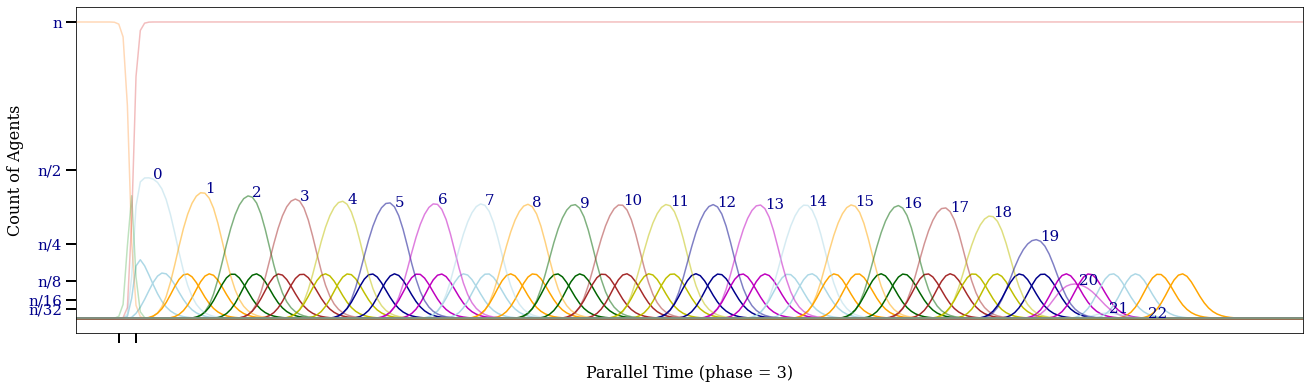

In [ ]:
#@title Plot distributions of hours and minutes

hour_colors = ['lightblue', 'orange', 'darkgreen', 'brown', 'y','darkblue', 'm']
minute_colors = []
for c in hour_colors:
  for i in range(int(k_value)):
    minute_colors.append(c)


# ax = df_phase.plot(figsize = (12,6), alpha =0.2, legend=False) 
ax = df_minutes.plot(figsize = (22,6), color=minute_colors, legend=False)
ax.set_xlabel("Parallel Time (phase = 3)", fontdict= font_large)
ax.set_ylabel("Count of Agents", fontdict= font_large)


build_dataframe(hour_key).plot(ax=ax, color = hour_colors, alpha=0.5, legend=False)
df_phase.plot(ax=ax, alpha=0.3, legend=False)
# ax.set_ylim(0, max_yaxis)


# # add labels to minutes lines
# for col in df_minutes.columns:
#     printed = True
#     for id, val in enumerate(df_minutes[col]):
#         if printed and val > _N/8 and int(col)%4 ==0:
#           printed = False
#           ax.text(id, _N/4, str(col), fontdict=font)

# add labels to hour lines
for col in df_hour.columns:
    printed = True
    old = 0 
    for id, val in enumerate(df_hour[col]):
        if printed and old > val:
          printed = False
          # ax.text(id, val, str(col), fontdict=font)
          ax.text(id, val + 100, str(col), fontdict=font)
        old = val

phase_label , phase_tikz, phase_starts, phase_ends, empty_phase_labels = gen_phase_tikz(df_phase)

# #set x axis labels to phase numbers
ax.set_xticks(phase_tikz, minor=False)
ax.set_xticklabels(empty_phase_labels, fontdict=font, minor=False)
ax.tick_params('both', length=10, width=2, which='major')

#set y axis labels to fractions of n
ax.set_yticks(ytikz, minor=False)
ax.set_yticklabels(ylabel, fontdict=font, minor=False)
# ax.set_ylim(0, (0.6)*_N)
# show only phase 3
ax.set_xlim(phase_tikz[2] - 10, phase_tikz[5] - 10)

# export files
fig = ax.get_figure()
fig.savefig('minute_hour_k_5.svg')
fig.savefig('minute_hour_k_5.pdf')

# Old Code

In [ ]:
ax = build_dataframe(field_name= output_key).plot(figsize = (22,6))

#set x axis labels to phase numbers
ax.set_xticks(phase_tikz, minor=False)
ax.set_xticklabels(empty_phase_labels, fontdict=font, minor=False)
ax.tick_params('both', length=10, width=2, which='major')

ax.legend(loc=2, prop={'size': 16})
df_phase.plot(ax=ax, alpha =0.2, legend=False) 
ax.set_xlabel("Parallel Time", fontdict= font_large)
ax.set_ylabel("Count of Agents", fontdict= font_large)

# export files
fig = ax.get_figure()
fig.savefig('output_phase.svg')
fig.savefig('output_phase.pdf')

In [ ]:
df_exp = build_dataframe(exponent_key, role_limit=Role.Main)
df_exp_a = build_dataframe(exponent_key, bias_limit= 1, role_limit= Role.Main)
df_exp_b = build_dataframe(exponent_key, bias_limit= -1, role_limit= Role.Main)
phase_label , phase_tikz, phase_starts, phase_ends, empty_phase_labels = gen_phase_tikz(df_phase, 2) #case of 3 extra points in phase 3

In [ ]:
#@title Plotting functions
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

def state_bar_plot_old(data, time, yscale = "linear"):
  # print(data)
  dist = [data[i][time] for i in range(-_LOG, 0)]
  plt.figure(figsize=(12,6))
  plt.bar(range(-_LOG, 0),dist)
  plt.title(f"Time step {time}")
  
  plt.yscale(yscale)
  plt.ylim(bottom = 1, top = _N)
  plt.show()

def state_bar_plot(data, time, col, yscale = "log"):
  dist = np.array([data[i][time] for i in range(-_LOG, 1)])
  plt.figure(figsize=(12,6))
  # Width of a bar 
  width = 0.7       
  a = np.array([i+width/2 for i in range(-_LOG, 1)])  
  # Plotting
  plt.bar(a,dist, width, label='col Exponents', color=col)
  # plt.set_color('r')
  plt.ylabel('Count of Agents')
  plt.xlabel('Exponent Values')
  plt.title(f"Time step {time}")
  
  for i, v in enumerate(dist):
    if v != 0 :
      plt.text(a[i] - 0.25, v + 10, str(v), color='darkblue', fontweight='bold')

  plt.yscale(yscale)
  plt.ylim(bottom = 1, top = _N)
  plt.show()

def a_b_exp_bar_plot(time, a_exp, b_exp, yscale = "linear", ymax=_N):
  a_exp_dist = np.array([a_exp[i][time] for i in range(-_LOG, 1)])
  b_exp_dist = np.array([b_exp[i][time] for i in range(-_LOG, 1)])

  # Figure size
  plt.figure(figsize=(12,6))

  # Width of a bar 
  width = 0.4       
  a = np.array([i+width/2 for i in range(-_LOG, 1)])
  b = np.array([i-width/2 for i in range(-_LOG, 1)])
  # Plotting
  plt.bar(b,b_exp_dist, width, label='B Exponents', color= 'darkblue', alpha=0.9)
  plt.bar(a,a_exp_dist, width, label='A Exponents', color= 'brown', alpha = 0.9)

  plt.ylabel('Count of Agents', fontdict=font)
  plt.xlabel('Exponent Values', fontdict= font)
  plt.xticks(range(-_LOG, 10), fontsize = 16)
  plt.title(f"Time step {time}")

  
  # xticks()
  # First argument - A list of positions at which ticks should be placed
  # Second argument -  A list of labels to place at the given locations
  # plt.xticks(ind + width / 2, ('Xtick1', 'Xtick3', 'Xtick3'))
  minx = 100
  maxx = -1  
  maxy = -1
  for i, v in enumerate(b_exp_dist):    
    if v != 0 :
      minx = min(i, minx)
      maxx = max(i, maxx)
      maxy = max(v, maxy)
      plt.text(b[i] - 0.4, v * 1.3, str(v), color='blue', fontsize=14)
  print(maxx-_LOG, minx-_LOG)
  for i, v in enumerate(a_exp_dist):
    if v != 0 :
      minx = min(i, minx)
      maxx = max(i, maxx)
      maxy = max(v, maxy)
      plt.text(a[i] - 0.2, v * 1.3, str(v), color='brown', fontsize=14)

  plt.xlim(minx-_LOG-3, maxx-_LOG+3)  
  plt.yscale(yscale)

  #set y axis labels to fractions of n
  plt.yticks(ytikz, ylabel, fontsize = '16')#, fontdict=font)
  
  plt.ylim(bottom = 1, top = min(_N/2, max(_N/16 , 2*maxy)))
  # plt.savefig("exponents_"+str(time)+".pdf")
  plt.show()
  
  # no_b_exp_dist = a_exp_dist - b_exp_dist
  # plt.figure(figsize=(12,6))
  # plt.bar(range(0,_LOG),b_exp_dist)
  # plt.bar(range(0,_LOG),b_exp_dist, bottom = no_b_exp_dist)
  # plt.legend(["No b_exp","b_exp"])
  # plt.title(f"Time step {time}")
  # plt.yscale(yscale)
  # plt.ylim(bottom = 1, top = _N)
  # plt.show()


In [1]:
#@title Old codes
# m = np.amax(np.array((df_exp[phase_ends[1]:phase_ends[3]].max(axis=0))))
# print(m)
# # for i in np.arange(phase_tikz[2]-9, phase_ends[3]+20, 20):  
# for i in np.arange(93, phase_ends[3]+20, 20):  
#   a_b_exp_bar_plot(a_exp = df_exp_a, b_exp = df_exp_b, time = i, ymax = m)
#   # state_bar_plot(data = df_exp_a, time = i, col = 'brown')
#   # state_bar_plot(data = df_exp_b, time = i, col = 'blue')

# # interesting_times = [90, 250, 390]
# # for v in interesting_times:
# #   a_b_exp_bar_plot(a_exp = df_exp_a, b_exp = df_exp_b, time = v, ymax = m)
  
#   # fig.savefig('exponents_'+v+'.svg')
  
# # for i in range(3,6):
# #   interact(state_bar_plot, data = fixed(df_exp_a), time = widgets.IntSlider(min=0, max=2000, step=1, value=phase_tikz[i]), col = 'red', yscale = ["linear", "log"])
# #   interact(state_bar_plot, data = fixed(df_exp_b), time = widgets.IntSlider(min=0, max=2000, step=1, value=phase_tikz[i]), col = 'blue', yscale = ["linear", "log"])
# # max = np.amax(np.array((df_exp[phase_ends[1]:phase_ends[3]].max(axis=0))))
# # interact(a_b_exp_bar_plot, a_exp = fixed(df_exp_a), b_exp = fixed(df_exp_b), time = widgets.IntSlider(min=phase_ends[1], max=phase_ends[3], step=1, value=0), yscale = ["linear", "log"], ymax = max)